In [1]:
# libraries from caselaw_20200411_brendan
import json
import lzma
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import re
from tqdm import tqdm
from IPython.core.display import display, HTML
import re
from nltk.tokenize import RegexpTokenizer

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

**Explanation of EDA**

I'm borrowing heavily from Brendan's code to just parse data.

I believe that measure token length can be useful, but right now we do not have a good idea of what our actual training/validation set is going to be.

To figure out what we can actually train, I used the Arkansas data as a starting point, and demonstrated below how (via human-eye, not computationally) word length can be a good indicator for classifying whether an observation (i.e. case) has a useable headmatter that we can train off of. 

If you disagree or think another approach is necessary for figuring out what is the "trainable" data in this dataset, please let me know.

In [2]:
tokenizer = RegexpTokenizer('\s+', gaps=True)

In [16]:
# I have a data_text and data_xml folder for both types since it looks like the existing
# notebooks from the three of you appear to take very different folder organizational 
# approaches. 
# Just fill in the correct pathway yourself to run.
with lzma.open('../cs109b/fin_temp/data_xml/N_Carolina_xml/data/data.jsonl.xz', 'r') as jsonl_file:
    cases = []
    for case in jsonl_file:
        c = json.loads(str(case, 'utf-8'))
        cases.append(c)

FileNotFoundError: [Errno 2] No such file or directory: '../cs109b/fin_temp/data_xml/N_Carolina_xml/data/data.jsonl.xz'

In [4]:
display(len(cases))

num_headnotes = []
num_opinions = []

for c in cases:
    headnotes = c['casebody']['data']['head_matter']
    num_headnotes.append(len(headnotes))
    opinions = c['casebody']['data']['opinions']
    num_opinions.append(len(opinions))

59735

In [5]:
# Dispaly one text of headmatter
c['casebody']['data']['head_matter']

'Earl Ray GARDNER v. STATE of Arkansas\nCR 77-196\n569 S.W. 2d 74\nOpinion delivered June 26, 1978\n(In Banc)\n[Rehearing denied September 5, 1978]\nLesher & Franks, for appellant.\nBill Clinton, Atty. Gen., by: Jesse L. Kearney, Asst. Atty. Gen., for appellee.'

In [15]:
#Confirm that all cases have headmatter, and how many have a zero-length headmatter
num_headnotes = np.array(num_headnotes)
num_headnotes_nonan = np.nan_to_num(num_headnotes, nan=0)
np.unique(np.array(num_headnotes))

array([195, 187, 173, ..., 165, 277, 253])

In [7]:
#Confirm that there are no NaN, and that there are few zero length headmatterdisplay(len(num_headnotes[num_headnotes == 0]))
display(len(num_headnotes_nonan[num_headnotes_nonan == 0]))

display(len(num_headnotes[num_headnotes < 100]))

7

317

In [8]:
#Save indices, and sort by length of headmatter for visualization
hdnotes_df = pd.DataFrame(num_headnotes, range(len(num_headnotes)))
hdnotes_sort = hdnotes_df.sort_values(by=[0])

/Users/akirasato/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


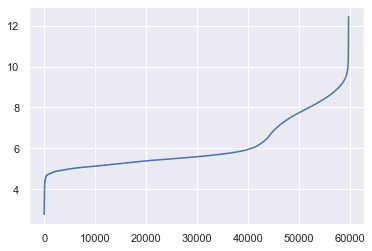

In [9]:
#plot log-lengths. We see "elbows" at x=7, x~400, x~42000, and x~60000
plt.plot(range(len(num_headnotes)),np.log(hdnotes_sort[0]));

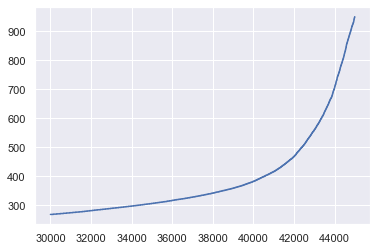

In [10]:
#Focus at the elbow between (sort) indices 30000 and 45000 
fig, ax = plt.subplots()
rnge_start = 30000
rnge_end = 45000
ax.plot(range(rnge_start, rnge_end),hdnotes_sort[0].values[rnge_start:rnge_end]);

In [11]:
# Trying to find a general "boundary" with human-eye for when headmatters appears to 
# become real summaries of opinion text, RATHER than just list of officials
short_hds_lst = hdnotes_sort.loc[((hdnotes_sort[0]<573) & (hdnotes_sort[0]>1))]
short_hds_lst.tail(10)

,0
27179,570
18011,570
3085,570
48056,571
58932,571
50351,571
51218,572
51814,572
49969,572
41636,572


In [12]:
# Drawing from two of the idices noted above, we see that one case clearly is a real 
# headmatter summary, while the other is just a list of officials involved.
# This suggests that somewhere between 550 and 600 words long, our headmatter can possibly
# be read by a human-being as a real summary headmatter
display(cases[49969]['casebody']['data']['head_matter'])
display(cases[27179]['casebody']['data']['head_matter'])

'2015 Ark. 285\nGary SANFORD; Linda Yeager; Wayne Lilley; Lilley Paint Co., Inc., an Arkansas Corporation; and Airmotive, Inc., an Arkansas Corporation, Appellants, v. Larry WALTHER, Director, Arkansas Department of Finance and Administration, Appellee.\nNo. CV-14-1056\nSupreme Court of Arkansas.\nOpinion Delivered June 25, 2015\nDeininger & Wingfield, P.A., Little Rock, by: Neil Deininger and Reba M. Wingfield; Hatfield & Sayre, Little Rock, by: Eugene G. Sayre; and Stephen L. Gurry, for appellants.\nJoel DiPippa, Attorney Supervisor, Revenue Legal Counsel, for appellees.'

'Parker v. Wilson.\nOpinion delivered June 12, 1911.\nStay bond — guaedian may Givg. — (Kirby’s Digest, § 3253, as amended by Acts of 1909, p. 590, providing that “no stay shall be allowed upon a judgment or decree against any* * agent for * * * failing to pay over money collected by him in such capacity,” does not prohibit a stay upon a judgment in favor of.a ward against his guardian for money collected by the guardian, a"s such, and not paid to the ward.\n/. W. House and Ratcliffe, Fletcher & Ratcliffe, for appellants.\nThomas & Lee and Johnson & Burr, for appellee.'

In [13]:
# This is the rough estimate about the number of training/validation data points we can use,
# assuming that word length is a good indicator of a "real" headmatter
len(hdnotes_sort) - len(short_hds_lst)

16627

In [14]:
# Possible, though tedious alternative to this very rough attempt: 
# We tag about 1000 to 2000 indices as "real" vs. "fake" headmatter, then just train an
# algorithm (e.g. CNN) to detect and classify for us. 